In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5   ZBTB8B  \
Patient_ID                                            ...                     
55_control    1.000000  0.363133  0.374212  0.611161  ...      0.0  0.71077   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...      0.0  0.00000   
72_control    0.648401  0.134017  0.200420  0.679453  ...      0.0  0.00000   
120_control   0.579519  0.248934  0.759250  0.755407  ...      0.0  0.00000   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...      0.0  0.00000   
...                ...       ...       ...       ...  ...      ...      ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...      0.0  0.00000   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...      0.0  0.00000   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...      0.0  0.00000   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...      0.0  0.00000   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...      0.0  0.00000   

              EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  C6orf106  \
Patient_ID                                                                     
55_control          0.0       0.564155      0.0  0.410548      0.0  0.466889   
168_CD_plain        0.0       0.619646      0.0  0.576526      0.0  0.247033   
72_control          0.0       0.978062      0.0  0.322280      0.0  0.809681   
120_control         0.0       0.630496      0.0  0.633583      0.0  0.568599   
258_CD_plain        0.0       0.575404      0.0  0.754246      0.0  0.349619   
...                 ...            ...      ...       ...      ...       ...   
15_CD_plain         0.0       0.424522      0.0  0.647019      0.0  0.358576   
182_CD_plain        0.0       0.643529      0.0  0.676222      0.0  0.534238   
164_CD_plain        0.0       0.592646      0.0  0.784037      0.0  0.401977   
53_CD_plain         0.0       0.503764      0.0  0.726674      0.0  0.482674   
97_CD_plain         0.0       0.480415      0.0  0.702185      0.0  0.809611   

              RPL7AP54     LCE2A  
Patient_ID                        
55_control         0.0  1.000000  
168_CD_plain       0.0  0.008198  
72_control         0.0  0.618383  
120_control        0.0  0.208173  
258_CD_plain       0.0  0.000000  
...                ...       ...  
15_CD_plain        0.0  0.000000  
182_CD_plain       0.0  0.646805  
164_CD_plain       0.0  0.232271  
53_CD_plain        0.0  0.000000  
97_CD_plain        0.0  0.461059  

[182 rows x 220 columns]

In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...      0.0   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...      0.0   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...      0.0   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...      0.0   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...      0.0   
...                     ...       ...       ...       ...  ...      ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...      0.0   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...      0.0   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...      0.0   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...      0.0   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
253_CD_plain          0.0        0.0       0.790435      0.0  0.849076   
105_CD_plain          0.0        0.0       0.917793      0.0  0.604771   
2_CD_plain            0.0        0.0       0.063827      0.0  0.703353   
184_CD_plain          0.0        0.0       0.650608      0.0  0.749070   
312_CD_plain          0.0        0.0       0.481745      0.0  0.717561   
...                   ...        ...            ...      ...       ...   
107_CD_plain          0.0        0.0       0.486418      0.0  0.625206   
279_CD_plain          0.0        0.0       0.217050      0.0  0.889784   
179_CD_plain          0.0        0.0       0.492356      0.0  0.744538   
70_CD_deep_ulcer      0.0        0.0       0.518714      0.0  0.461913   
256_CD_deep_ulcer     0.0        0.0       0.591308      0.0  0.713509   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
253_CD_plain           0.0  0.686223       0.0  0.395101  
105_CD_plain           0.0  0.668052       0.0  0.671177  
2_CD_plain             0.0  0.826523       0.0  0.000000  
184_CD_plain           0.0  0.548091       0.0  0.134641  
312_CD_plain           0.0  0.541235       0.0  0.000000  
...                    ...       ...       ...       ...  
107_CD_plain           0.0  0.722622       0.0  0.000000  
279_CD_plain           0.0  0.514313       0.0  0.000000  
179_CD_plain           0.0  0.494143       0.0  0.165054  
70_CD_deep_ulcer       0.0  0.528017       0.0  0.000000  
256_CD_deep_ulcer      0.0  0.587452       0.0  0.000000  

[78 rows x 220 columns]

In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('../data/models/cd_encoder')

In [7]:
compound_model.summary()

NameError: name 'compound_model' is not defined

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [8]:
idx = 41

In [9]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [10]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [11]:

with open("../data/models/shap/ind_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [12]:
# shap_values[0][0].shape

In [13]:
shap_values = shap_values[0]

In [14]:
# shap_values[0] *= 100000

In [15]:
shap_values

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.19569468,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.51608404,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.42906391, -0.54060641,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.0572052 ,  0.        ,  0.        ,  0.        , -1.13559276,
          0.        ,  0.        ,  0.        ,  0.        , -0.21866958,
          0.        ,  0.        ,  0.

In [16]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [17]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
260_CD_deep_ulcer     0.0        0.0       0.652111      0.0  0.876483   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
260_CD_deep_ulcer      0.0  0.551273       0.0  0.262322  

[1 rows x 220 columns]

In [18]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [8.47204378e-26 5.59485119e-01 4.40514881e-01]
Predicted class: 1


#### Control

In [19]:
import shap

In [20]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [21]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [23]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

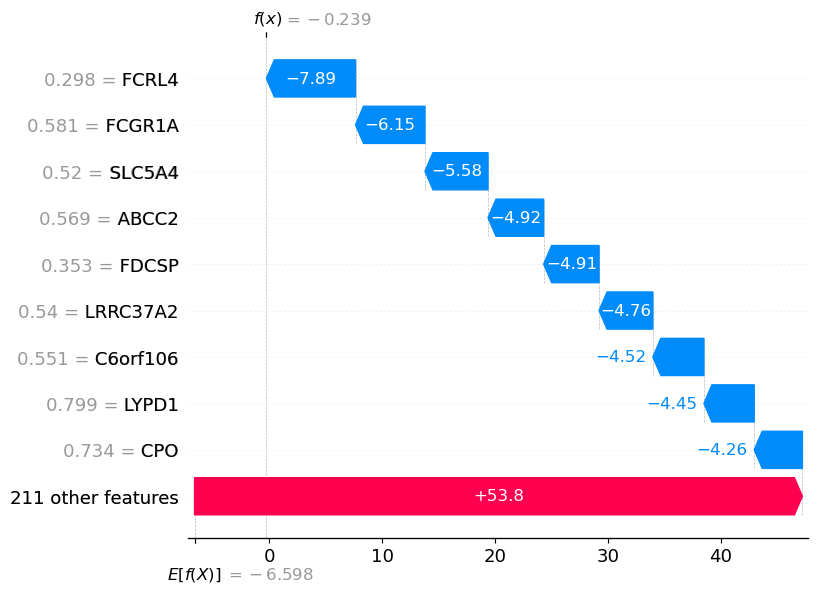

In [24]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [25]:
idx = 41

In [26]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [77]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [78]:

with open("../data/models/shap/fd_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [79]:
# shap_values[0][0].shape

In [80]:
shap_values = shap_values[0]

In [81]:
# shap_values[0] *= 100000

In [82]:
shap_values

[array([[ -9.68526523,  13.76446308, -31.85145105,  53.95341941,
           0.        ,  18.12901329, -21.25053628,  68.55865242,
           0.        , -13.30997914, -17.69046978,   0.        ,
           0.        ,   0.        ,  57.12682094,   0.        ,
           0.        , -42.18744217, -16.18203642, -15.22578677,
         -18.63485659,  24.20229513, -29.72534101, -22.63934033,
           0.        , -47.42081424, -19.61830665, -26.63981203,
           0.        ,  -2.89672796,   0.        , -26.67151937,
           0.66498952,   0.        ,   0.        ,  26.43447293,
          66.05443082,  14.41270053,   0.        ,   8.91471921,
           0.        ,  39.38897164,  77.15799101,   0.        ,
          -6.8795698 ,   0.        ,  11.08564837,  69.83299188,
           0.        ,   0.        ,   0.        ,   6.94389856,
          -3.08706286, -37.45977427,  34.71127429,  19.6901171 ,
          -0.27047367,  30.34290035,  19.26153657,   0.        ,
         -30.73494309, -2

In [83]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [84]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     MICA  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.69275   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
260_CD_deep_ulcer        0.0        0.0  0.486189  0.553708  0.569272   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
260_CD_deep_ulcer  0.530402    0.28222  0.529513       0.0  

[1 rows x 220 columns]

In [86]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

1/1 [==============================] - 0s 12ms/step
Prediction probabilities for patient: [0.07070122 0.6113825  0.3179162 ]
1/1 [==============================] - 0s 15ms/step
Predicted class: 1


#### Control

In [87]:
import shap

In [88]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [89]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [90]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [91]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

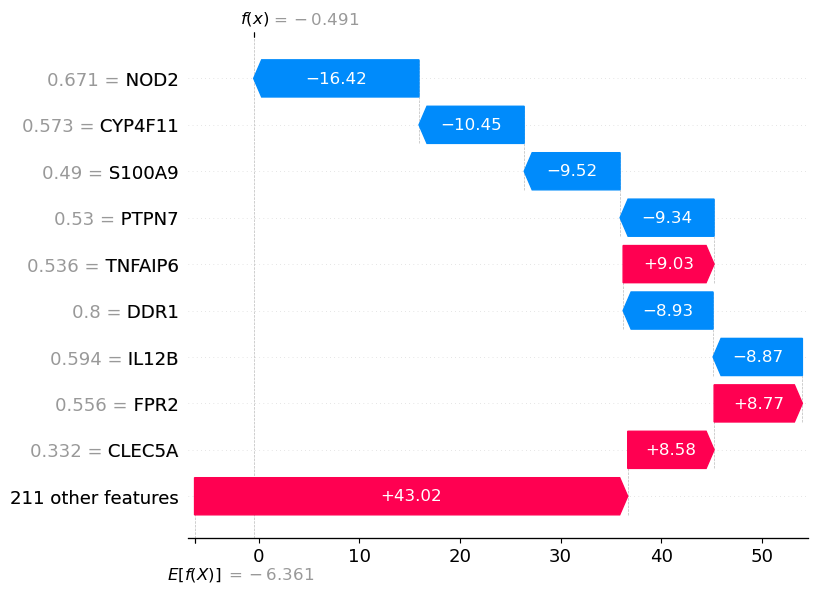

In [92]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [58]:
idx = 18

In [59]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [60]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [61]:

with open("../data/models/shap/fd_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [62]:
# shap_values[0][0].shape

In [63]:
shap_values = shap_values[0]

In [64]:
# shap_values[0] *= 100000

In [65]:
shap_values

[array([[  0.        ,   8.18022669,  -0.43773856,  18.66341286,
          -3.49432271,   0.        ,   0.        ,  21.27738225,
           0.        ,   0.        ,   0.        ,   0.        ,
         -10.42091467,  12.74227674,   0.        ,   0.        ,
          16.64594405,   0.        ,   0.        ,  -9.72675331,
          -2.73940279,   6.10226348, -10.2382546 ,   0.        ,
           0.        ,   0.        ,  -2.11029044,   0.        ,
           0.15260211,  -4.64523792,  -8.54133633,   0.        ,
           5.72605473,   0.        ,   0.        ,   3.1732591 ,
           0.        ,  -1.96119886,   0.        ,   7.55502642,
           0.        , -11.49924996,   0.        ,   0.        ,
          -8.02462279,  -6.81370718,   0.        ,   0.        ,
          -5.18251766,   0.        , -16.55966071,   0.        ,
         -18.90497408, -26.51049404,   0.        ,   0.        ,
          19.21374873, -23.00315586,   0.        ,   4.92892974,
           0.        ,  1

In [66]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [67]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [68]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.09615204e-23 9.39813301e-01 6.01866987e-02]
Predicted class: 1


#### Control

In [69]:
import shap

In [70]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [71]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [72]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [73]:
# deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

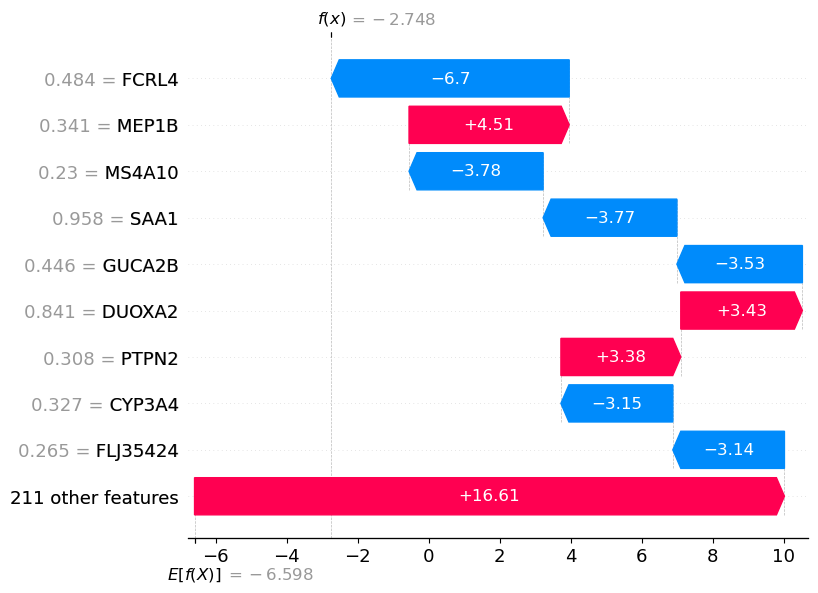

In [74]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [75]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


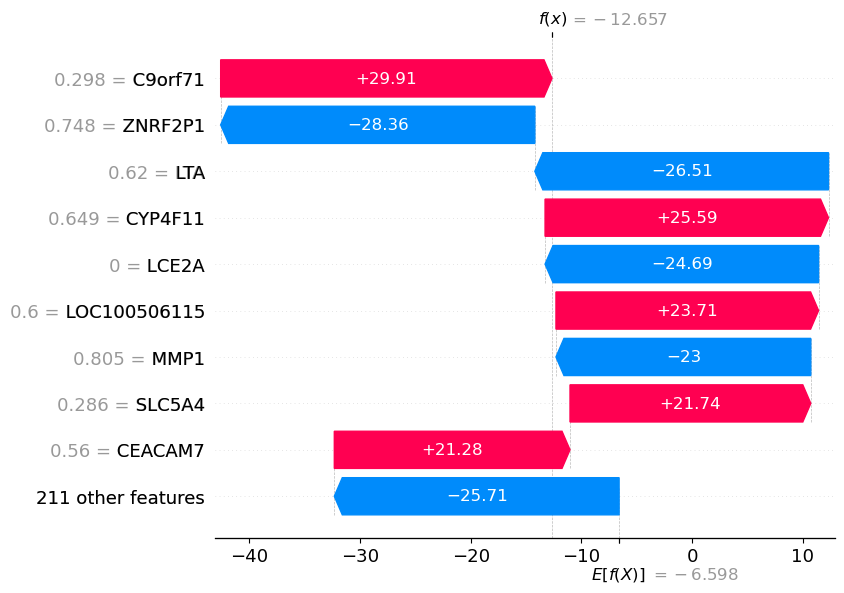

In [76]:
shap.waterfall_plot(explanation)

## Independent - 18

In [43]:
idx = 18

In [44]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [45]:


with open("../data/models/shap/ind_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [46]:
shap_values = shap_values[0]

In [47]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [48]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [49]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.09615204e-23 9.39813301e-01 6.01866987e-02]
Predicted class: 1


#### Control

In [50]:
import shap

In [51]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [52]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [53]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [54]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
#deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

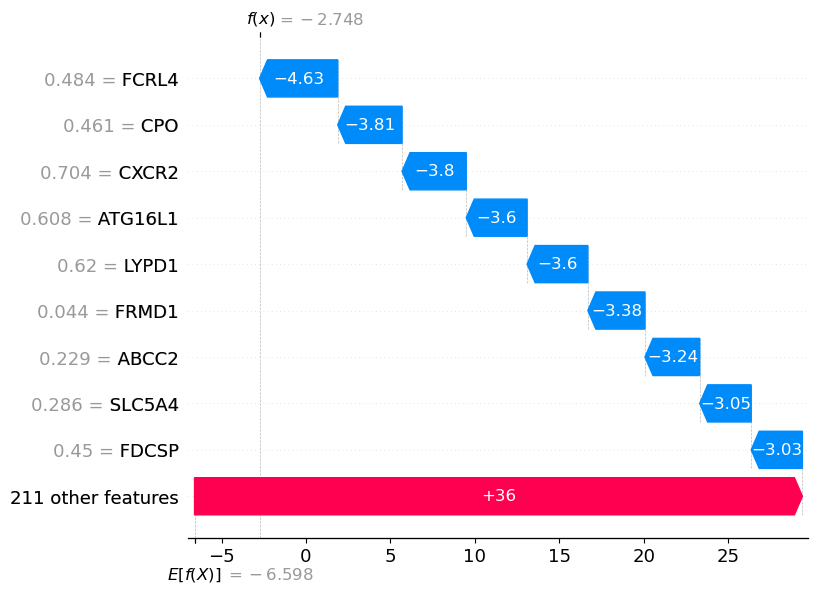

In [55]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [56]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


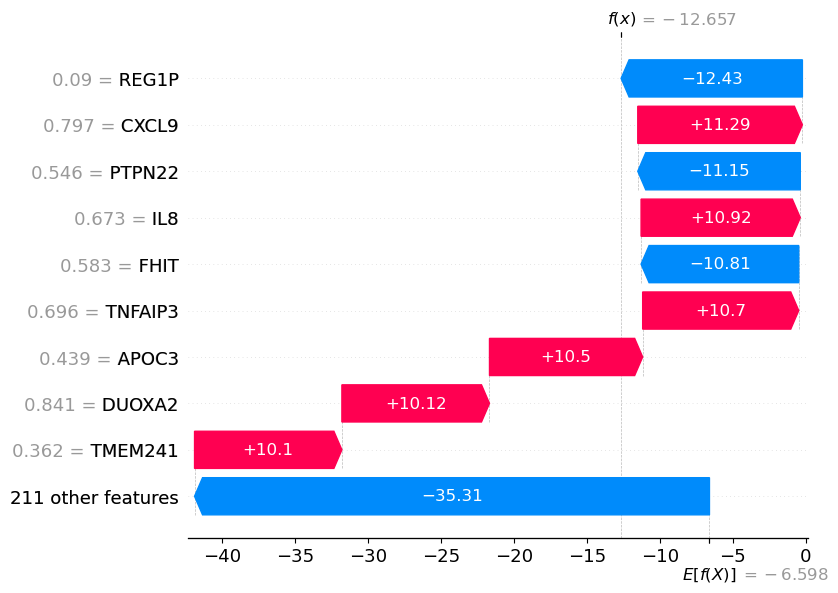

In [57]:
shap.waterfall_plot(explanation)

## Independent - 77

In [25]:
idx = 77

In [26]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [27]:


with open("../data/models/shap/ind_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [28]:
shap_values = shap_values[0]

In [29]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [30]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...      MICA  LOC646430  \
Patient_ID                                           ...                        
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.598137        0.0   

                   LOC441956     ITGAV   SMCHD1      ASPN    TMEM97  \
Patient_ID                                                            
256_CD_deep_ulcer        0.0  0.550635  0.71262  0.543815  0.510634   

                   LOC389458     PTPN7  RPS12P31  
Patient_ID                                        
256_CD_deep_ulcer    0.02108  0.597887       0.0  

[1 rows x 220 columns]

In [31]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0])

Prediction probabilities for patient: [0.33333333 0.33333333 0.33333333]
Predicted class:


#### Control

In [32]:
import shap

In [33]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [34]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [35]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [36]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

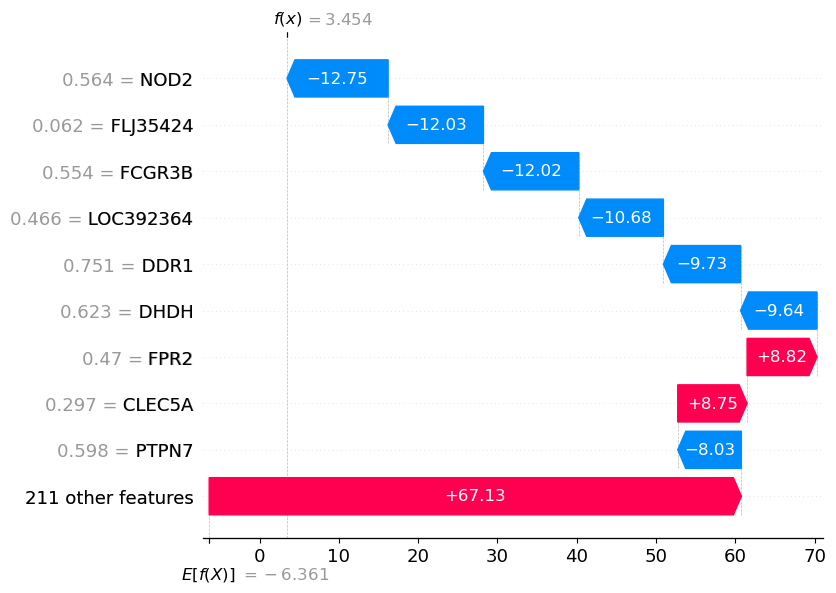

In [37]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 77

In [38]:
idx = 77

In [39]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [40]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [41]:

with open("../data/models/shap/fd_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [42]:
# shap_values[0][0].shape

In [43]:
shap_values = shap_values[0]

In [44]:
# shap_values[0] *= 100000

In [45]:
shap_values

[array([[  0.        ,  23.50100874,   0.        ,  65.90762829,
           0.        ,   4.20591465, -37.51589846,  29.67753812,
           0.        ,   0.        ,  -8.39378678,   5.30596393,
          -6.10288803, -16.99286877,  24.2721339 ,   0.        ,
           0.        , -32.07030243,   0.        , -31.92017819,
          -7.29068935,  56.76391996,   0.        , -25.58015653,
          10.9691045 , -34.06704161, -34.85773197, -17.18706606,
         -74.81517708, -33.76527527,   8.32061789, -41.57740627,
         -32.39658095, -34.51179369,   5.02275813,  -2.18514121,
           0.        ,  12.06499085,   0.        ,   0.        ,
         -22.01896881, -24.36575218,  17.53162919,   0.        ,
          -2.74642673,   0.        , -32.60283189,  17.70633646,
           0.        ,   0.        ,   0.        , -24.98507714,
           0.        ,   0.        ,  20.89340258,   0.        ,
          51.79214801,  17.84700901,  22.05486456,   0.        ,
         -31.32293089, -2

In [46]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [47]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...      MICA  LOC646430  \
Patient_ID                                           ...                        
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.598137        0.0   

                   LOC441956     ITGAV   SMCHD1      ASPN    TMEM97  \
Patient_ID                                                            
256_CD_deep_ulcer        0.0  0.550635  0.71262  0.543815  0.510634   

                   LOC389458     PTPN7  RPS12P31  
Patient_ID                                        
256_CD_deep_ulcer    0.02108  0.597887       0.0  

[1 rows x 220 columns]

In [48]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0])

1/1 [==============================] - 0s 101ms/step
Prediction probabilities for patient: [0.10381257 0.6050999  0.2910875 ]
Predicted class:


#### Control

In [49]:
import shap

In [50]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [51]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [52]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [55]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

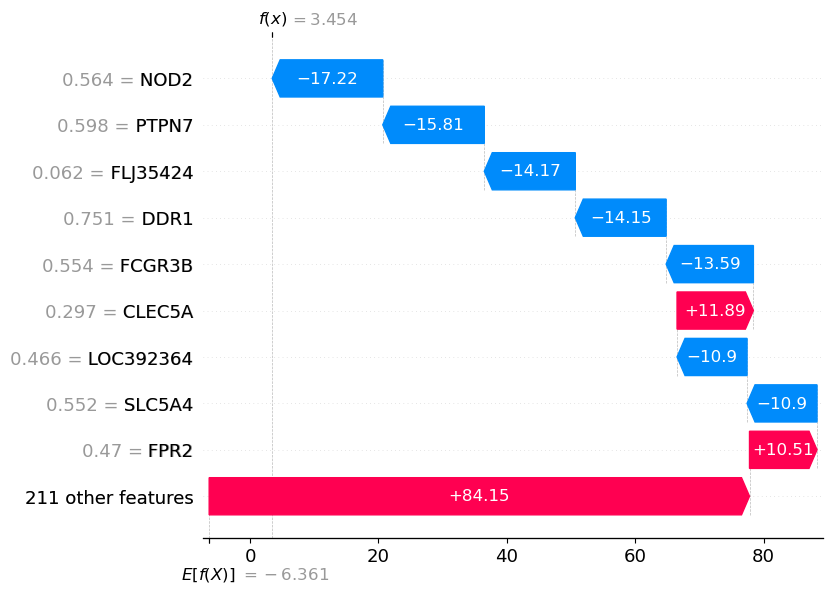

In [56]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))